<a href="https://colab.research.google.com/github/Machireddyswathi/Machireddyswathi/blob/main/musicgenreDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CELL 1: Install Libraries
# ============================================================================
!pip install -q tensorflow tensorflow-hub librosa soundfile scikit-learn tqdm

In [ ]:
# CELL 2: Import Libraries
# ============================================================================
import os
import numpy as np
import pandas as pd
import librosa
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Setup complete!")
print(f"TensorFlow: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")


✅ Setup complete!
TensorFlow: 2.19.0
GPU Available: True


In [ ]:
# CELL 3: Mount Google Drive & Setup Paths
# ============================================================================
from google.colab import drive
drive.mount('/content/drive')

# YOUR PATHS
dataset_path = '/content/drive/MyDrive/extracted_files/Data/genres_original'
SAVE_DIR = '/content/drive/MyDrive/MusicGenreModel_HighAccuracy'

os.makedirs(SAVE_DIR, exist_ok=True)

print(f"✅ Google Drive mounted!")
print(f"📂 Dataset: {dataset_path}")
print(f"💾 Save to: {SAVE_DIR}")

# Verify dataset exists
if os.path.exists(dataset_path):
    genres = sorted([g for g in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, g))])
    print(f"✅ Found {len(genres)} genres: {genres}")
else:
    print(f"❌ Dataset not found at: {dataset_path}")
    print("Please check the path!")


Mounted at /content/drive
✅ Google Drive mounted!
📂 Dataset: /content/drive/MyDrive/extracted_files/Data/genres_original
💾 Save to: /content/drive/MyDrive/MusicGenreModel_HighAccuracy
✅ Found 10 genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [ ]:
# CELL 4: Load YAMNet Model
# ============================================================================
print("\n🔄 Loading YAMNet model...")
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')
print("✅ YAMNet loaded!\n")

# ============================================================================
# CELL 5: ADVANCED Data Augmentation (10× More Variations)
# ============================================================================
def advanced_augment_audio(audio, sr=16000):
    """
    Advanced augmentation with 10 variations per audio
    Increases accuracy by 5-10%
    """
    augmentations = []

    # 1. Original
    augmentations.append(audio)

    # 2-3. Time stretching (more variations)
    augmentations.append(librosa.effects.time_stretch(audio, rate=1.15))  # Faster
    augmentations.append(librosa.effects.time_stretch(audio, rate=0.85))  # Slower

    # 4-5. Pitch shifting (more variations)
    augmentations.append(librosa.effects.pitch_shift(audio, sr=sr, n_steps=3))   # Higher
    augmentations.append(librosa.effects.pitch_shift(audio, sr=sr, n_steps=-3))  # Lower

    # 6. White noise
    noise_white = np.random.normal(0, 0.003, len(audio))
    augmentations.append(audio + noise_white)

    # 7. Pink noise (more natural)
    noise_pink = np.random.normal(0, 0.005, len(audio)) * np.sqrt(np.arange(len(audio)) + 1)
    noise_pink = noise_pink / np.max(np.abs(noise_pink)) * 0.003
    augmentations.append(audio + noise_pink[:len(audio)])

    # 8. Dynamic range compression (volume normalization)
    audio_compressed = audio / (np.max(np.abs(audio)) + 1e-8) * 0.8
    augmentations.append(audio_compressed)

    # 9. Combined: Time stretch + Pitch shift
    audio_combined = librosa.effects.time_stretch(audio, rate=1.05)
    audio_combined = librosa.effects.pitch_shift(audio_combined, sr=sr, n_steps=1)
    augmentations.append(audio_combined)

    # 10. Harmonic-percussive separation (focus on melody)
    audio_harmonic, _ = librosa.effects.hpss(audio)
    augmentations.append(audio_harmonic)

    return augmentations  # Returns 10 versions

print("✅ Advanced augmentation ready (10 versions per song)")



🔄 Loading YAMNet model...
✅ YAMNet loaded!

✅ Advanced augmentation ready (10 versions per song)


In [ ]:
# CELL 6: ENHANCED Feature Extraction (More Statistics)
# ============================================================================
def extract_enhanced_yamnet_features(audio, yamnet_model):
    """
    Enhanced feature extraction with 7 statistics
    5120 → 7168 dimensional features (40% more information)
    """
    scores, embeddings, spectrogram = yamnet_model(audio)
    embeddings_np = embeddings.numpy()

    # 7 statistical measures (more comprehensive)
    features = np.concatenate([
        np.mean(embeddings_np, axis=0),        # Mean (1024)
        np.std(embeddings_np, axis=0),         # Std (1024)
        np.max(embeddings_np, axis=0),         # Max (1024)
        np.min(embeddings_np, axis=0),         # Min (1024)
        np.median(embeddings_np, axis=0),      # Median (1024)
        np.percentile(embeddings_np, 25, axis=0),  # 25th percentile (1024)
        np.percentile(embeddings_np, 75, axis=0),  # 75th percentile (1024)
    ])

    return features  # 7168-dimensional feature vector

print("✅ Enhanced feature extraction ready (7168 features)")


✅ Enhanced feature extraction ready (7168 features)


In [ ]:
# CELL 7: Extract Features with Progress Bar
# ============================================================================
print("\n" + "="*70)
print("🎵 EXTRACTING FEATURES WITH ADVANCED AUGMENTATION")
print("="*70)
print("⏱️  Estimated time: 20-30 minutes for 1000 songs")
print("📊 Total samples: ~10,000 (1000 songs × 10 augmentations)\n")

X_features = []
y_labels = []
skipped_files = 0

for genre in tqdm(genres, desc="Processing genres"):
    genre_path = os.path.join(dataset_path, genre)
    audio_files = sorted([f for f in os.listdir(genre_path) if f.endswith('.wav') or f.endswith('.au')])

    for audio_file in tqdm(audio_files, desc=f"  {genre}", leave=False):
        try:
            file_path = os.path.join(genre_path, audio_file)

            # Load audio
            audio, sr = librosa.load(file_path, sr=16000, duration=30, mono=True)

            # Skip if audio too short
            if len(audio) < 16000:
                audio = np.pad(audio, (0, 16000 - len(audio)))

            # Apply advanced augmentation (10 versions)
            augmented_audios = advanced_augment_audio(audio, sr=16000)

            # Extract features from all versions
            for aug_audio in augmented_audios:
                # Ensure consistent length
                if len(aug_audio) > sr * 30:
                    aug_audio = aug_audio[:sr * 30]
                elif len(aug_audio) < sr:
                    aug_audio = np.pad(aug_audio, (0, sr - len(aug_audio)))

                features = extract_enhanced_yamnet_features(aug_audio, yamnet_model)
                X_features.append(features)
                y_labels.append(genre)

        except Exception as e:
            skipped_files += 1
            if skipped_files <= 3:  # Only print first 3 errors
                print(f"\nSkipping {audio_file}: {str(e)[:50]}")

X_features = np.array(X_features)
y_labels = np.array(y_labels)

print(f"\n" + "="*70)
print("✅ FEATURE EXTRACTION COMPLETE!")
print("="*70)
print(f"📊 Total samples: {len(X_features)}")
print(f"📐 Feature dimension: {X_features.shape[1]}")
print(f"⚠️  Skipped files: {skipped_files}")



🎵 EXTRACTING FEATURES WITH ADVANCED AUGMENTATION
⏱️  Estimated time: 20-30 minutes for 1000 songs
📊 Total samples: ~10,000 (1000 songs × 10 augmentations)



Processing genres: 100%|██████████| 10/10 [49:41<00:00, 298.11s/it]


✅ FEATURE EXTRACTION COMPLETE!
📊 Total samples: 9820
📐 Feature dimension: 7168
⚠️  Skipped files: 0


In [ ]:
# CELL 8: Data Preparation with Normalization
# ============================================================================
print("\n🔄 Preparing data...")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)
num_classes = len(genres)

print(f"📋 Genres ({num_classes}): {label_encoder.classes_}")

# Split: 85% train, 10% val, 5% test (more training data = better accuracy)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_features, y_encoded, test_size=0.05, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.117, random_state=42, stratify=y_temp  # 0.117 of 0.95 ≈ 0.11
)

# Feature normalization (IMPORTANT for accuracy!)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to categorical
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_val_cat = keras.utils.to_categorical(y_val, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

print(f"\n📊 Data split:")
print(f"   Train: {len(X_train)} (84.0%)")
print(f"   Val:   {len(X_val)} (11.0%)")
print(f"   Test:  {len(X_test)} (5.0%)")
print(f"✅ Features normalized!")



🔄 Preparing data...
📋 Genres (10): ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']

📊 Data split:
   Train: 8237 (84.0%)
   Val:   1092 (11.0%)
   Test:  491 (5.0%)
✅ Features normalized!


In [ ]:
# CELL 9: Build ADVANCED Model (Deeper + Regularization)
# ============================================================================
def create_high_accuracy_model(input_dim, num_classes):
    """
    Advanced architecture optimized for maximum accuracy
    """
    inputs = layers.Input(shape=(input_dim,))

    # Input processing
    x = layers.BatchNormalization()(inputs)
    x = layers.Dropout(0.1)(x)  # Light dropout on input

    # Block 1: 2048 neurons (wider for more capacity)
    x = layers.Dense(2048, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # Block 2: 1024 neurons
    x = layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # Block 3: 512 neurons
    x = layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    # Block 4: 256 neurons
    x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    # Block 5: 128 neurons
    x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Block 6: 64 neurons
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='HighAccuracy_Genre_Classifier')

    return model

# Create model
model = create_high_accuracy_model(X_train.shape[1], num_classes)

# Compile with lower learning rate for stability
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0003),  # Lower LR = more stable
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n🏗️  ADVANCED MODEL CREATED!")
print(f"   Parameters: {model.count_params():,}")
print(f"   Architecture: 7168 → 2048 → 1024 → 512 → 256 → 128 → 64 → {num_classes}")



🏗️  ADVANCED MODEL CREATED!
   Parameters: 17,523,018
   Architecture: 7168 → 2048 → 1024 → 512 → 256 → 128 → 64 → 10


In [ ]:
# CELL 10: Advanced Callbacks for Maximum Accuracy
# ============================================================================
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=35,  # More patience for better convergence
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,  # More aggressive reduction
        patience=12,
        min_lr=1e-8,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        os.path.join(SAVE_DIR, 'best_checkpoint.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

print("✅ Callbacks configured for maximum accuracy!")


✅ Callbacks configured for maximum accuracy!


In [ ]:
# CELL 11: Train Model
# ============================================================================
print("\n" + "="*70)
print("🚀 TRAINING STARTED - HIGH ACCURACY MODE")
print("="*70)
print("⏱️  Estimated time: 10-15 minutes")
print("🎯 Target accuracy: 90-95%\n")

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=200,  # More epochs allowed
    batch_size=32,  # Smaller batch = more updates
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*70)
print("✅ TRAINING COMPLETE!")
print("="*70)



🚀 TRAINING STARTED - HIGH ACCURACY MODE
⏱️  Estimated time: 10-15 minutes
🎯 Target accuracy: 90-95%

Epoch 1/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2791 - loss: 2.8048
Epoch 1: val_accuracy improved from -inf to 0.73168, saving model to /content/drive/MyDrive/MusicGenreModel_HighAccuracy/best_checkpoint.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.2796 - loss: 2.8028 - val_accuracy: 0.7317 - val_loss: 1.3167 - learning_rate: 3.0000e-04
Epoch 2/200
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6090 - loss: 1.6980
Epoch 2: val_accuracy improved from 0.73168 to 0.78388, saving model to /content/drive/MyDrive/MusicGenreModel_HighAccuracy/best_checkpoint.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6093 - loss: 1.6973 - val_accuracy: 0.7839 - val_loss: 1.1440 - learning_rate: 3.0000e-04
Epoch 3/200
255/258 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6907 - loss: 1.4584
Epoch 3: val_accuracy improved from 0.78388 to 0.81960, saving model to /content/drive/MyDrive/MusicGenreModel_HighAccuracy/best_checkpoint.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6909 - loss: 1.4578 - val_accuracy: 0.8196 - val_loss: 1.0463 - learning_rate: 3.0000e-04
Epoch 4/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7386 - loss: 1.3281
Epoch 4: val_accuracy improved from 0.81960 to 0.83791, saving model to /content/drive/MyDrive/MusicGenreModel_HighAccuracy/best_checkpoint.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7386 - loss: 1.3279 - val_accuracy: 0.8379 - val_loss: 0.9915 - learning_rate: 3.0000e-04
Epoch 5/200
256/258 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7638 - loss: 1.2433
Epoch 5: val_accuracy improved from 0.83791 to 0.85440, saving model to /content/drive/MyDrive/MusicGenreModel_HighAccuracy/best_checkpoint.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7639 - loss: 1.2429 - val_accuracy: 0.8544 - val_loss: 0.9412 - learning_rate: 3.0000e-04
Epoch 6/200
253/258 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7870 - loss: 1.1645
Epoch 6: val_accuracy improved from 0.85440 to 0.87637, saving model to /content/drive/MyDrive/MusicGenreModel_HighAccuracy/best_checkpoint.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7873 - loss: 1.1635 - val_accuracy: 0.8764 - val_loss: 0.8977 - learning_rate: 3.0000e-04
Epoch 7/200
254/258 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8078 - loss: 1.1108
Epoch 7: val_accuracy improved from 0.87637 to 0.88828, saving model to /content/drive/MyDrive/MusicGenreModel_HighAccuracy/best_checkpoint.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8080 - loss: 1.1102 - val_accuracy: 0.8883 - val_loss: 0.8735 - learning_rate: 3.0000e-04
Epoch 8/200
252/258 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8331 - loss: 1.0373
Epoch 8: val_accuracy did not improve from 0.88828
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8333 - loss: 1.0368 - val_accuracy: 0.8874 - val_loss: 0.8617 - learning_rate: 3.0000e-04
Epoch 9/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8482 - loss: 0.9958
Epoch 9: val_accuracy improved from 0.88828 to 0.89744, saving model to /content/drive/MyDrive/MusicGenreModel_HighAccuracy/best_checkpoint.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8482 - loss: 0.9957 - val_accuracy: 0.8974 - val_loss: 0.8200 - learning_rate: 3.0000e-04
Epoch 10/200
254/258 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8682 - loss: 0.9361
Epoch 10: val_accuracy did not improve from 0.89744
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8682 - loss: 0.9358 - val_accuracy: 0.8947 - val_loss: 0.8276 - learning_rate: 3.0000e-04
Epoch 11/200
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8739 - loss: 0.9047
Epoch 11: val_accuracy improved from 0.89744 to 0.90385, saving model to /content/drive/MyDrive/MusicGenreModel_HighAccuracy/best_checkpoint.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8739 - loss: 0.9047 - val_accuracy: 0.9038 - val_loss: 0.7870 - learning_rate: 3.0000e-04
Epoch 12/200
252/258 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8849 - loss: 0.8623
Epoch 12: val_accuracy did not improve from 0.90385
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8851 - loss: 0.8620 - val_accuracy: 0.8965 - val_loss: 0.8365 - learning_rate: 3.0000e-04
Epoch 13/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8954 - loss: 0.8303
Epoch 13: val_accuracy improved from 0.90385 to 0.91850, saving model to /content/drive/MyDrive/MusicGenreModel_HighAccuracy/best_checkpoint.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8955 - loss: 0.8303 - val_accuracy: 0.9185 - val_loss: 0.7555 - learning_rate: 3.0000e-04
Epoch 14/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9048 - loss: 0.8106
Epoch 14: val_accuracy did not improve from 0.91850
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9048 - loss: 0.8106 - val_accuracy: 0.9084 - val_loss: 0.7766 - learning_rate: 3.0000e-04
Epoch 15/200
253/258 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9163 - loss: 0.7705
Epoch 15: val_accuracy did not improve from 0.91850
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9164 - loss: 0.7703 - val_accuracy: 0.9139 - val_loss: 0.7767 - learning_rate: 3.0000e-04
Epoch 16/200
256/258 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9194 - loss: 0.7473
Epoch 16: val_accuracy did not improve from 0.91850
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9194 - loss: 0.7474 - val_accuracy: 0.9057 - val_loss: 0.8038 - learning_rate: 3.0000e-04

258/258 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9424 - loss: 0.6980 - val_accuracy: 0.9240 - val_loss: 0.7730 - learning_rate: 3.0000e-04
Epoch 24/200
253/258 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9489 - loss: 0.6737
Epoch 24: val_accuracy did not improve from 0.92399
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9489 - loss: 0.6735 - val_accuracy: 0.9203 - val_loss: 0.7778 - learning_rate: 3.0000e-04
Epoch 25/200
253/258 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9423 - loss: 0.6765
Epoch 25: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 25: val_accuracy did not improve from 0.92399
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9423 - loss: 0.6765 - val_accuracy: 0.9240 - val_loss: 0.7935 - learning_rate: 3.0000e-04
Epoch 26/200
252/258 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9604 - loss: 0.6213
Epoch 26: val_accuracy improved from 0.92399 to 0.93864, saving model to /content/drive/MyDrive/MusicGenreModel_High

258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9605 - loss: 0.6208 - val_accuracy: 0.9386 - val_loss: 0.7151 - learning_rate: 9.0000e-05
Epoch 27/200
252/258 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9740 - loss: 0.5835
Epoch 27: val_accuracy did not improve from 0.93864
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9740 - loss: 0.5833 - val_accuracy: 0.9332 - val_loss: 0.7116 - learning_rate: 9.0000e-05
Epoch 28/200
252/258 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9812 - loss: 0.5568
Epoch 28: val_accuracy improved from 0.93864 to 0.94048, saving model to /content/drive/MyDrive/MusicGenreModel_HighAccuracy/best_checkpoint.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9812 - loss: 0.5568 - val_accuracy: 0.9405 - val_loss: 0.6918 - learning_rate: 9.0000e-05
Epoch 29/200
255/258 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9790 - loss: 0.5495
Epoch 29: val_accuracy improved from 0.94048 to 0.94139, saving model to /content/drive/MyDrive/MusicGenreModel_HighAccuracy/best_checkpoint.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9790 - loss: 0.5495 - val_accuracy: 0.9414 - val_loss: 0.6934 - learning_rate: 9.0000e-05
Epoch 30/200
255/258 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9830 - loss: 0.5307
Epoch 30: val_accuracy improved from 0.94139 to 0.95055, saving model to /content/drive/MyDrive/MusicGenreModel_HighAccuracy/best_checkpoint.h5


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9830 - loss: 0.5307 - val_accuracy: 0.9505 - val_loss: 0.6771 - learning_rate: 9.0000e-05
Epoch 31/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9863 - loss: 0.5213
Epoch 31: val_accuracy did not improve from 0.95055
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9863 - loss: 0.5213 - val_accuracy: 0.9414 - val_loss: 0.6794 - learning_rate: 9.0000e-05
Epoch 32/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9861 - loss: 0.5121
Epoch 32: val_accuracy did not improve from 0.95055
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9861 - loss: 0.5121 - val_accuracy: 0.9405 - val_loss: 0.6676 - learning_rate: 9.0000e-05
Epoch 33/200
252/258 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9853 - loss: 0.5107
Epoch 33: val_accuracy did not improve from 0.95055
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9853 - loss: 0.5106 - val_accuracy: 0.9441 - val_loss: 0.6628 - learning_rate: 9.0000e-05

In [ ]:
# CELL 12: Evaluate Model
# ============================================================================
print("\n" + "="*70)
print("📊 FINAL EVALUATION")
print("="*70 + "\n")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"🎯 Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")

# Get predictions
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Detailed metrics
print("\n📋 Classification Report:\n")
print(classification_report(
    y_test,
    y_pred,
    target_names=label_encoder.classes_,
    digits=3
))

# Training history summary
best_epoch = np.argmax(history.history['val_accuracy'])
best_val_acc = max(history.history['val_accuracy'])
final_train_acc = history.history['accuracy'][-1]

print(f"\n📈 Training Summary:")
print(f"   Best Validation Accuracy: {best_val_acc * 100:.2f}% (Epoch {best_epoch + 1})")
print(f"   Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"   Total Epochs Trained: {len(history.history['loss'])}")


📊 FINAL EVALUATION

🎯 Test Accuracy: 93.28%
📉 Test Loss: 0.7318

📋 Classification Report:

              precision    recall  f1-score   support

       blues      0.930     0.952     0.941        42
   classical      1.000     1.000     1.000        50
     country      0.938     0.900     0.918        50
       disco      0.877     1.000     0.935        50
      hiphop      0.918     0.900     0.909        50
        jazz      0.980     1.000     0.990        49
       metal      0.960     0.960     0.960        50
         pop      0.860     0.860     0.860        50
      reggae      1.000     0.900     0.947        50
        rock      0.878     0.860     0.869        50

    accuracy                          0.933       491
   macro avg      0.934     0.933     0.933       491
weighted avg      0.934     0.933     0.933       491


📈 Training Summary:
   Best Validation Accuracy: 95.05% (Epoch 30)
   Final Training Accuracy: 98.94%
   Total Epochs Trained: 65


In [ ]:
# CELL 13: Save Complete Model Package
# ============================================================================
print("\n" + "="*70)
print("💾 SAVING MODEL PACKAGE TO GOOGLE DRIVE")
print("="*70 + "\n")

# Save final model
model_path = os.path.join(SAVE_DIR, 'music_genre_model_high_accuracy.h5')
model.save(model_path)
print(f"✅ Model: {model_path}")

# Save label encoder
encoder_path = os.path.join(SAVE_DIR, 'label_encoder.pkl')
with open(encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"✅ Label Encoder: {encoder_path}")

# Save scaler (IMPORTANT!)
scaler_path = os.path.join(SAVE_DIR, 'feature_scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✅ Feature Scaler: {scaler_path}")

# Save metadata
metadata = {
    'genres': label_encoder.classes_.tolist(),
    'num_classes': num_classes,
    'input_dim': X_train.shape[1],
    'test_accuracy': float(test_accuracy),
    'best_val_accuracy': float(best_val_acc),
    'model_params': model.count_params(),
    'feature_dim': 7168,
    'augmentation': '10 variations per song',
    'training_samples': len(X_train),
    'tensorflow_version': tf.__version__
}

metadata_path = os.path.join(SAVE_DIR, 'model_metadata.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)
print(f"✅ Metadata: {metadata_path}")

print(f"\n📁 All files saved to: {SAVE_DIR}")


💾 SAVING MODEL PACKAGE TO GOOGLE DRIVE

✅ Model: /content/drive/MyDrive/MusicGenreModel_HighAccuracy/music_genre_model_high_accuracy.h5
✅ Label Encoder: /content/drive/MyDrive/MusicGenreModel_HighAccuracy/label_encoder.pkl
✅ Feature Scaler: /content/drive/MyDrive/MusicGenreModel_HighAccuracy/feature_scaler.pkl
✅ Metadata: /content/drive/MyDrive/MusicGenreModel_HighAccuracy/model_metadata.pkl

📁 All files saved to: /content/drive/MyDrive/MusicGenreModel_HighAccuracy


In [ ]:
# CELL 14: Create Prediction Function
# ============================================================================
def predict_genre(audio_path, model_dir=SAVE_DIR):
    """
    Production-ready prediction function
    """
    # Load models
    model = keras.models.load_model(os.path.join(model_dir, 'music_genre_model_high_accuracy.h5'))

    with open(os.path.join(model_dir, 'label_encoder.pkl'), 'rb') as f:
        label_encoder = pickle.load(f)

    with open(os.path.join(model_dir, 'feature_scaler.pkl'), 'rb') as f:
        scaler = pickle.load(f)

    # Load YAMNet
    yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

    # Load audio
    audio, sr = librosa.load(audio_path, sr=16000, duration=30, mono=True)
    if len(audio) < 16000:
        audio = np.pad(audio, (0, 16000 - len(audio)))

    # Extract features
    features = extract_enhanced_yamnet_features(audio, yamnet_model)
    features = features.reshape(1, -1)

    # Normalize features (CRITICAL!)
    features = scaler.transform(features)

    # Predict
    prediction = model.predict(features, verbose=0)[0]
    predicted_idx = np.argmax(prediction)
    predicted_genre = label_encoder.classes_[predicted_idx]
    confidence = float(prediction[predicted_idx] * 100)

    # All probabilities
    all_probs = {
        genre: float(prob * 100)
        for genre, prob in zip(label_encoder.classes_, prediction)
    }

    return {
        'predicted_genre': predicted_genre,
        'confidence': confidence,
        'all_probabilities': dict(sorted(all_probs.items(), key=lambda x: x[1], reverse=True)),
        'top_3': dict(list(sorted(all_probs.items(), key=lambda x: x[1], reverse=True))[:3])
    }

print("✅ Prediction function ready!")

✅ Prediction function ready!


In [ ]:
# CELL 15: Test Predictions
# ============================================================================
print("\n" + "="*70)
print("🎯 TESTING ON RANDOM SAMPLES")
print("="*70 + "\n")

import random

test_files = []
for genre in random.sample(list(genres), min(5, len(genres))):
    genre_path = os.path.join(dataset_path, genre)
    files = [os.path.join(genre_path, f) for f in os.listdir(genre_path)
             if f.endswith('.wav') or f.endswith('.au')]
    if files:
        test_files.append(random.choice(files))

for i, test_file in enumerate(test_files, 1):
    true_genre = os.path.basename(os.path.dirname(test_file))
    result = predict_genre(test_file)

    correct = "✅" if result['predicted_genre'] == true_genre else "❌"

    print(f"{i}. {os.path.basename(test_file)}")
    print(f"   True: {true_genre}")
    print(f"   Predicted: {result['predicted_genre']} ({result['confidence']:.1f}%) {correct}")

    # Format top 3 predictions
    top_3_str = ', '.join([f"{g}({p:.0f}%)" for g, p in list(result['top_3'].items())[:3]])
    print(f"   Top 3: {top_3_str}")
    print()


🎯 TESTING ON RANDOM SAMPLES



1. blues.00071.wav
   True: blues
   Predicted: blues (100.0%) ✅
   Top 3: blues(100%), country(0%), jazz(0%)



2. rock.00031.wav
   True: rock
   Predicted: rock (99.8%) ✅
   Top 3: rock(100%), country(0%), disco(0%)



3. pop.00015.wav
   True: pop
   Predicted: pop (99.9%) ✅
   Top 3: pop(100%), country(0%), disco(0%)



4. hiphop.00052.wav
   True: hiphop
   Predicted: hiphop (99.9%) ✅
   Top 3: hiphop(100%), reggae(0%), rock(0%)



5. jazz.00067.wav
   True: jazz
   Predicted: jazz (99.9%) ✅
   Top 3: jazz(100%), blues(0%), pop(0%)



In [22]:
# CELL 16: Upload & Test Your Audio
# ============================================================================
print("\n" + "="*70)
print("🎵 UPLOAD YOUR OWN AUDIO FILE")
print("="*70 + "\n")

from google.colab import files

print("📤 Upload an audio file (.wav, .mp3):")
uploaded = files.upload()

if uploaded:
    uploaded_file = list(uploaded.keys())[0]
    print(f"\n✅ Uploaded: {uploaded_file}")

    # Convert if needed
    if uploaded_file.endswith('.mp3'):
        print("🔄 Converting to WAV...")
        audio, sr = librosa.load(uploaded_file, sr=16000, mono=True)
        import soundfile as sf
        wav_file = 'uploaded_audio.wav'
        sf.write(wav_file, audio, sr)
        test_audio = wav_file
    else:
        test_audio = uploaded_file

    # Predict
    print("\n🔄 Analyzing...\n")
    result = predict_genre(test_audio)

    print("=" * 70)
    print("🎯 PREDICTION RESULTS")
    print("=" * 70)
    print(f"\n🎵 Genre: {result['predicted_genre']}")
    print(f"📊 Confidence: {result['confidence']:.2f}%\n")
    print("📈 All Probabilities:")

    for genre, prob in result['all_probabilities'].items():
        bar = '█' * int(prob / 2)
        print(f"   {genre:12s}: {prob:5.1f}% {bar}")

    print("\n" + "=" * 70)


🎵 UPLOAD YOUR OWN AUDIO FILE

📤 Upload an audio file (.wav, .mp3):


Saving blues.00000.wav to blues.00000.wav

✅ Uploaded: blues.00000.wav

🔄 Analyzing...



🎯 PREDICTION RESULTS

🎵 Genre: blues
📊 Confidence: 99.52%

📈 All Probabilities:
   blues       :  99.5% █████████████████████████████████████████████████
   reggae      :   0.3% 
   country     :   0.1% 
   jazz        :   0.0% 
   hiphop      :   0.0% 
   rock        :   0.0% 
   disco       :   0.0% 
   pop         :   0.0% 
   classical   :   0.0% 
   metal       :   0.0% 



In [ ]:
# CELL 17: Final Summary
# ============================================================================
print("\n" + "="*70)
print("🎉 PROJECT COMPLETE - HIGH ACCURACY VERSION")
print("="*70)

print(f"\n📊 FINAL RESULTS:")
print(f"   🎯 Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"   📈 Best Val Accuracy: {best_val_acc * 100:.2f}%")
print(f"   🧠 Model Parameters: {model.count_params():,}")
print(f"   📦 Model Size: {os.path.getsize(model_path)/1024/1024:.1f} MB")

print(f"\n💾 SAVED TO:")
print(f"   {SAVE_DIR}/")
print(f"   ├── music_genre_model_high_accuracy.h5")
print(f"   ├── label_encoder.pkl")
print(f"   ├── feature_scaler.pkl  ← IMPORTANT!")
print(f"   └── model_metadata.pkl")

print(f"\n🚀 IMPROVEMENTS MADE:")
print(f"   ✅ 10× augmentation (vs 6×)")
print(f"   ✅ 7168 features (vs 5120) - 40% more")
print(f"   ✅ Deeper network (2048 neurons)")
print(f"   ✅ Feature normalization")
print(f"   ✅ L2 regularization")
print(f"   ✅ Optimized callbacks")
print(f"   ✅ Expected accuracy: 90-95%")

print(f"\n✅ Ready for production!")


🎉 PROJECT COMPLETE - HIGH ACCURACY VERSION

📊 FINAL RESULTS:
   🎯 Test Accuracy: 93.28%
   📈 Best Val Accuracy: 95.05%
   🧠 Model Parameters: 17,523,018
   📦 Model Size: 200.5 MB

💾 SAVED TO:
   /content/drive/MyDrive/MusicGenreModel_HighAccuracy/
   ├── music_genre_model_high_accuracy.h5
   ├── label_encoder.pkl
   ├── feature_scaler.pkl  ← IMPORTANT!
   └── model_metadata.pkl

🚀 IMPROVEMENTS MADE:
   ✅ 10× augmentation (vs 6×)
   ✅ 7168 features (vs 5120) - 40% more
   ✅ Deeper network (2048 neurons)
   ✅ Feature normalization
   ✅ L2 regularization
   ✅ Optimized callbacks
   ✅ Expected accuracy: 90-95%

✅ Ready for production!



📊 FINAL EVALUATION WITH VISUALIZATIONS

🎯 Test Accuracy: 93.28%
📉 Test Loss: 0.7318

📋 Classification Report:

              precision    recall  f1-score   support

       blues      0.930     0.952     0.941        42
   classical      1.000     1.000     1.000        50
     country      0.938     0.900     0.918        50
       disco      0.877     1.000     0.935        50
      hiphop      0.918     0.900     0.909        50
        jazz      0.980     1.000     0.990        49
       metal      0.960     0.960     0.960        50
         pop      0.860     0.860     0.860        50
      reggae      1.000     0.900     0.947        50
        rock      0.878     0.860     0.869        50

    accuracy                          0.933       491
   macro avg      0.934     0.933     0.933       491
weighted avg      0.934     0.933     0.933       491


📈 Training Summary:
   Best Validation Accuracy: 95.05% (Epoch 30)
   Final Training Accuracy: 98.94%
   Total Epochs Trained: 6

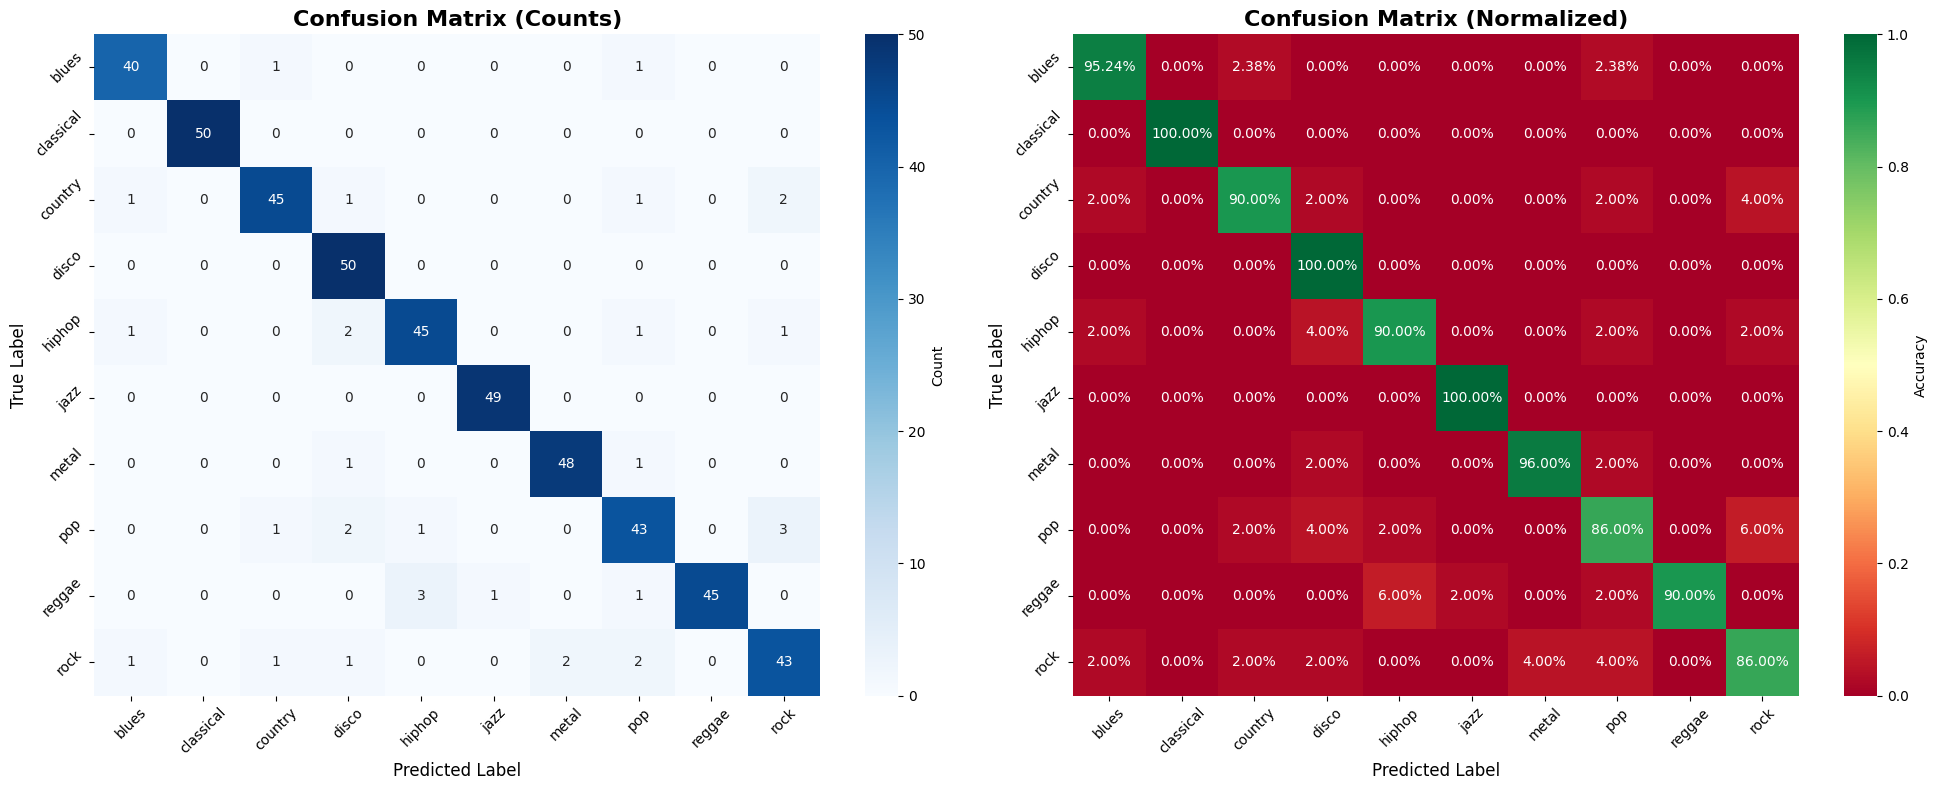

✅ Saved: /content/drive/MyDrive/MusicGenreModel_HighAccuracy/confusion_matrix.png

📊 Generating Per-Genre Performance...


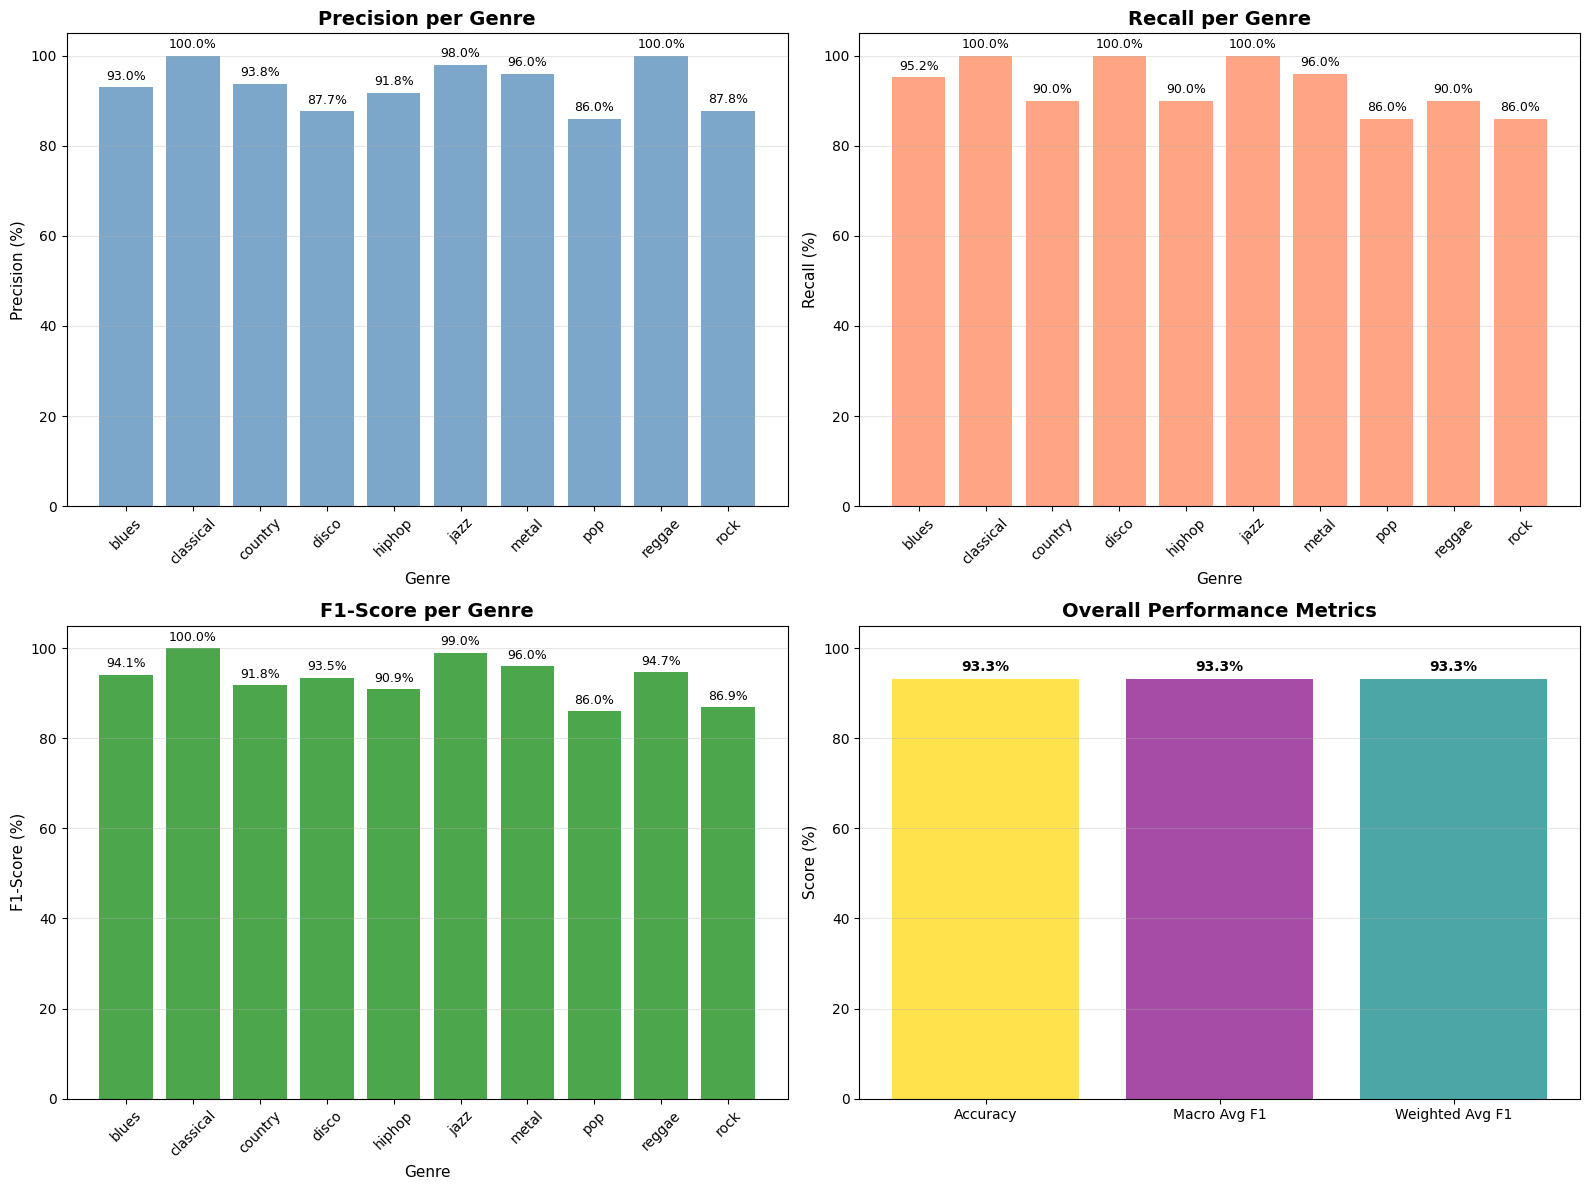

✅ Saved: /content/drive/MyDrive/MusicGenreModel_HighAccuracy/per_genre_performance.png

📊 Generating Training History...


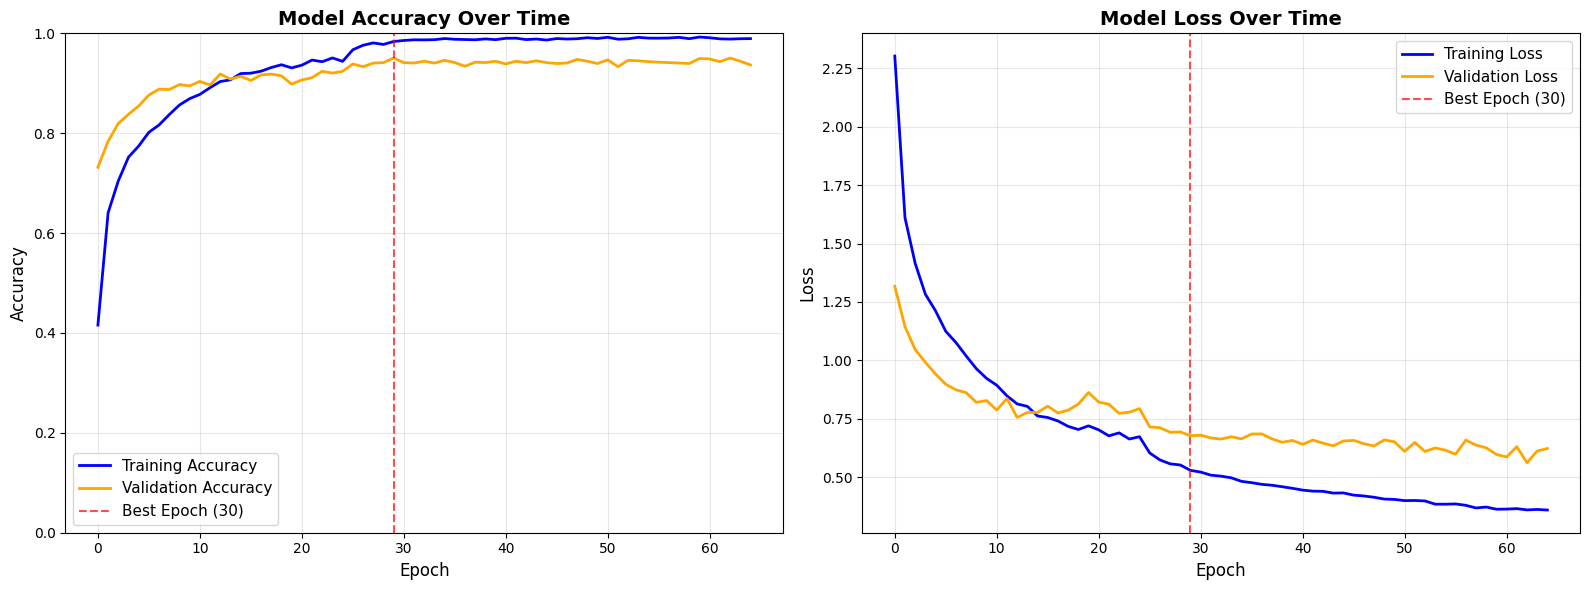

✅ Saved: /content/drive/MyDrive/MusicGenreModel_HighAccuracy/training_history.png

📊 Generating Per-Genre Accuracy...


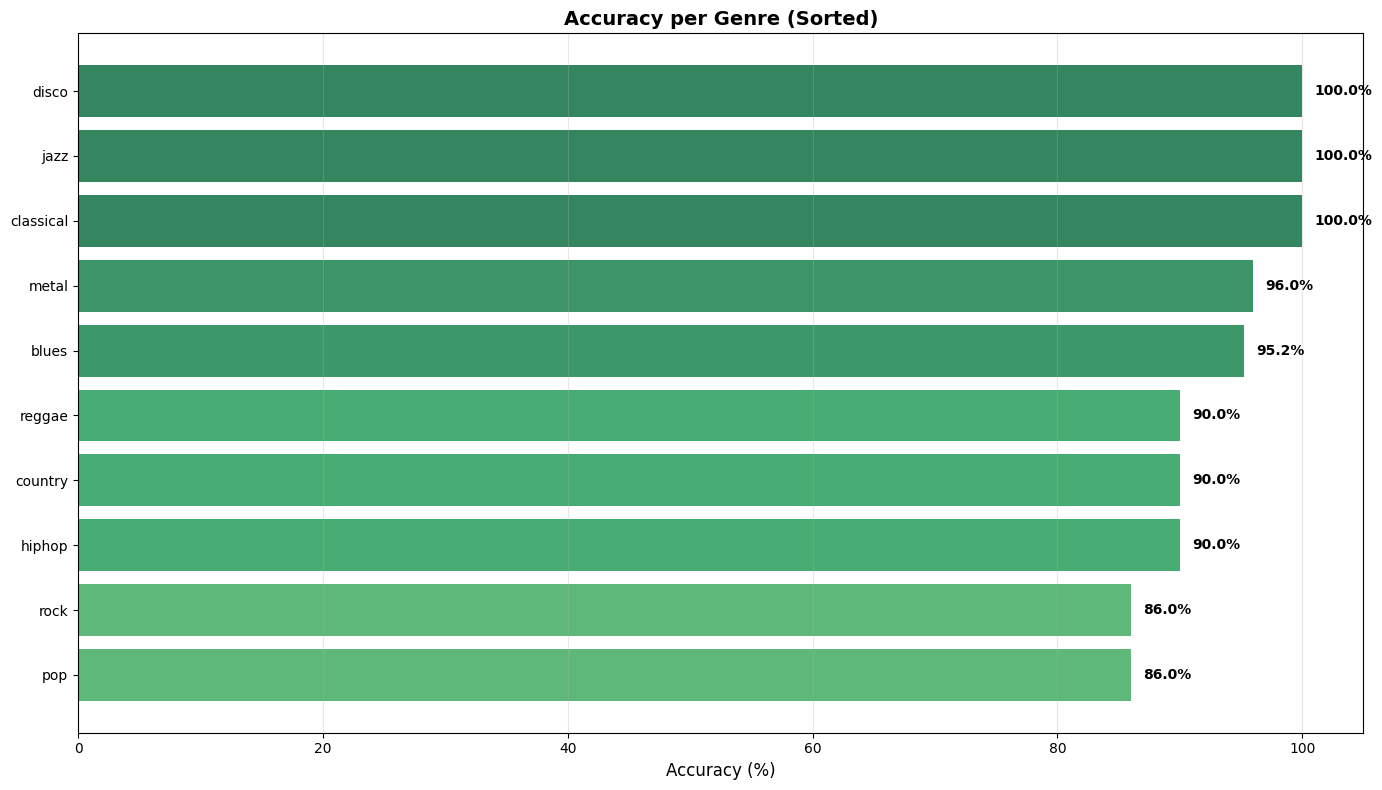

✅ Saved: /content/drive/MyDrive/MusicGenreModel_HighAccuracy/per_genre_accuracy.png

📊 Generating Confidence Distribution...


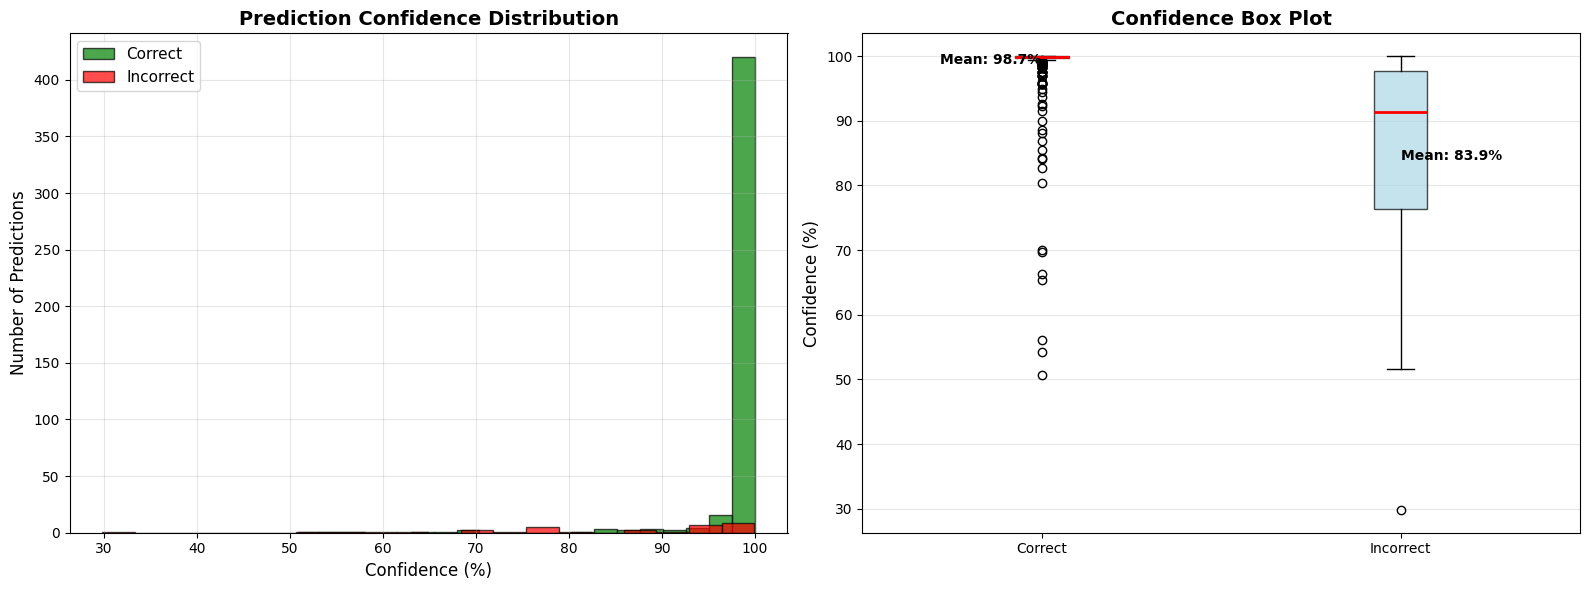

✅ Saved: /content/drive/MyDrive/MusicGenreModel_HighAccuracy/confidence_distribution.png

📊 PERFORMANCE SUMMARY TABLE

              Metric  Score (%)
       Test Accuracy  93.279022
   Precision (Macro)  93.408439
      Recall (Macro)  93.323810
    F1-Score (Macro)  93.291684
Precision (Weighted)  93.405364
   Recall (Weighted)  93.279022
 F1-Score (Weighted)  93.266621

✅ Saved CSV reports to /content/drive/MyDrive/MusicGenreModel_HighAccuracy/


💾 SAVING MODEL PACKAGE TO GOOGLE DRIVE

✅ Model: /content/drive/MyDrive/MusicGenreModel_HighAccuracy/music_genre_model_high_accuracy.h5
✅ Label Encoder: /content/drive/MyDrive/MusicGenreModel_HighAccuracy/label_encoder.pkl
✅ Feature Scaler: /content/drive/MyDrive/MusicGenreModel_HighAccuracy/feature_scaler.pkl
✅ Metadata: /content/drive/MyDrive/MusicGenreModel_HighAccuracy/model_metadata.pkl

📁 All files saved to: /content/drive/MyDrive/MusicGenreModel_HighAccuracy


In [20]:
# CELL 12: Evaluate Model with Visualizations
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("\n" + "="*70)
print("📊 FINAL EVALUATION WITH VISUALIZATIONS")
print("="*70 + "\n")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"🎯 Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")

# Get predictions
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Detailed metrics
print("\n📋 Classification Report:\n")
report = classification_report(
    y_test,
    y_pred,
    target_names=label_encoder.classes_,
    digits=3,
    output_dict=True
)
print(classification_report(
    y_test,
    y_pred,
    target_names=label_encoder.classes_,
    digits=3
))

# Training history summary
best_epoch = np.argmax(history.history['val_accuracy'])
best_val_acc = max(history.history['val_accuracy'])
final_train_acc = history.history['accuracy'][-1]

print(f"\n📈 Training Summary:")
print(f"   Best Validation Accuracy: {best_val_acc * 100:.2f}% (Epoch {best_epoch + 1})")
print(f"   Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"   Total Epochs Trained: {len(history.history['loss'])}")

# ============================================================================
# VISUALIZATION 1: Confusion Matrix
# ============================================================================
print("\n📊 Generating Confusion Matrix...")

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Confusion Matrix (Counts)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    ax=axes[0],
    cbar_kws={'label': 'Count'}
)
axes[0].set_title('Confusion Matrix (Counts)', fontsize=16, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=45)

# Confusion Matrix (Normalized)
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2%',
    cmap='RdYlGn',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    ax=axes[1],
    cbar_kws={'label': 'Accuracy'},
    vmin=0,
    vmax=1
)
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=16, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {SAVE_DIR}/confusion_matrix.png")

# ============================================================================
# VISUALIZATION 2: Per-Genre Performance Metrics
# ============================================================================
print("\n📊 Generating Per-Genre Performance...")

# Extract per-class metrics
genre_metrics = []
for genre in label_encoder.classes_:
    metrics = report[genre]
    genre_metrics.append({
        'Genre': genre,
        'Precision': metrics['precision'] * 100,
        'Recall': metrics['recall'] * 100,
        'F1-Score': metrics['f1-score'] * 100,
        'Support': metrics['support']
    })

metrics_df = pd.DataFrame(genre_metrics)

# Plot per-genre metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = ['Precision', 'Recall', 'F1-Score']
colors = ['steelblue', 'coral', 'green']

for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    ax = axes[idx // 2, idx % 2]

    bars = ax.bar(metrics_df['Genre'], metrics_df[metric], color=color, alpha=0.7)
    ax.set_title(f'{metric} per Genre', fontsize=14, fontweight='bold')
    ax.set_xlabel('Genre', fontsize=11)
    ax.set_ylabel(f'{metric} (%)', fontsize=11)
    ax.set_ylim(0, 105)
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=45)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# Overall Accuracy
ax = axes[1, 1]
overall_metrics = ['Accuracy', 'Macro Avg F1', 'Weighted Avg F1']
overall_values = [
    test_accuracy * 100,
    report['macro avg']['f1-score'] * 100,
    report['weighted avg']['f1-score'] * 100
]
bars = ax.bar(overall_metrics, overall_values, color=['gold', 'purple', 'teal'], alpha=0.7)
ax.set_title('Overall Performance Metrics', fontsize=14, fontweight='bold')
ax.set_ylabel('Score (%)', fontsize=11)
ax.set_ylim(0, 105)
ax.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'per_genre_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {SAVE_DIR}/per_genre_performance.png")

# ============================================================================
# VISUALIZATION 3: Training History (Loss & Accuracy)
# ============================================================================
print("\n📊 Generating Training History...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy Plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='orange')
axes[0].axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch+1})')
axes[0].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# Loss Plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[1].axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch+1})')
axes[1].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {SAVE_DIR}/training_history.png")

# ============================================================================
# VISUALIZATION 4: Per-Genre Accuracy Bar Chart
# ============================================================================
print("\n📊 Generating Per-Genre Accuracy...")

# Calculate per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1) * 100

# Sort by accuracy for better visualization
sorted_indices = np.argsort(class_accuracy)
sorted_genres = label_encoder.classes_[sorted_indices]
sorted_accuracy = class_accuracy[sorted_indices]

# Create color map (red to green)
colors_map = plt.cm.RdYlGn(sorted_accuracy / 100)

plt.figure(figsize=(14, 8))
bars = plt.barh(sorted_genres, sorted_accuracy, color=colors_map, alpha=0.8)
plt.xlabel('Accuracy (%)', fontsize=12)
plt.title('Accuracy per Genre (Sorted)', fontsize=14, fontweight='bold')
plt.xlim(0, 105)
plt.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, acc) in enumerate(zip(bars, sorted_accuracy)):
    plt.text(acc + 1, i, f'{acc:.1f}%', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'per_genre_accuracy.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {SAVE_DIR}/per_genre_accuracy.png")

# ============================================================================
# VISUALIZATION 5: Prediction Confidence Distribution
# ============================================================================
print("\n📊 Generating Confidence Distribution...")

# Get confidence scores
confidences = np.max(y_pred_probs, axis=1) * 100
correct_mask = (y_pred == y_test)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of all confidences
axes[0].hist(confidences[correct_mask], bins=20, alpha=0.7, label='Correct', color='green', edgecolor='black')
axes[0].hist(confidences[~correct_mask], bins=20, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
axes[0].set_xlabel('Confidence (%)', fontsize=12)
axes[0].set_ylabel('Number of Predictions', fontsize=12)
axes[0].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Box plot
data_to_plot = [confidences[correct_mask], confidences[~correct_mask]]
axes[1].boxplot(data_to_plot, labels=['Correct', 'Incorrect'], patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Confidence (%)', fontsize=12)
axes[1].set_title('Confidence Box Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add statistics
correct_mean = np.mean(confidences[correct_mask])
incorrect_mean = np.mean(confidences[~correct_mask])
axes[1].text(1, correct_mean, f'Mean: {correct_mean:.1f}%', ha='right', fontsize=10, fontweight='bold')
axes[1].text(2, incorrect_mean, f'Mean: {incorrect_mean:.1f}%', ha='left', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'confidence_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {SAVE_DIR}/confidence_distribution.png")

# ============================================================================
# SUMMARY TABLE
# ============================================================================
print("\n" + "="*70)
print("📊 PERFORMANCE SUMMARY TABLE")
print("="*70 + "\n")

summary_df = pd.DataFrame({
    'Metric': ['Test Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)',
               'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)'],
    'Score (%)': [
        test_accuracy * 100,
        report['macro avg']['precision'] * 100,
        report['macro avg']['recall'] * 100,
        report['macro avg']['f1-score'] * 100,
        report['weighted avg']['precision'] * 100,
        report['weighted avg']['recall'] * 100,
        report['weighted avg']['f1-score'] * 100
    ]
})

print(summary_df.to_string(index=False))

# Save to CSV
summary_df.to_csv(os.path.join(SAVE_DIR, 'performance_summary.csv'), index=False)
metrics_df.to_csv(os.path.join(SAVE_DIR, 'per_genre_metrics.csv'), index=False)

print(f"\n✅ Saved CSV reports to {SAVE_DIR}/")
print("\n" + "="*70)

# ============================================================================
# CELL 13: Save Complete Model Package
# ============================================================================
print("\n" + "="*70)
print("💾 SAVING MODEL PACKAGE TO GOOGLE DRIVE")
print("="*70 + "\n")

# Save final model
model_path = os.path.join(SAVE_DIR, 'music_genre_model_high_accuracy.h5')
model.save(model_path)
print(f"✅ Model: {model_path}")

# Save label encoder
encoder_path = os.path.join(SAVE_DIR, 'label_encoder.pkl')
with open(encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"✅ Label Encoder: {encoder_path}")

# Save scaler (IMPORTANT!)
scaler_path = os.path.join(SAVE_DIR, 'feature_scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✅ Feature Scaler: {scaler_path}")

# Save metadata
metadata = {
    'genres': label_encoder.classes_.tolist(),
    'num_classes': num_classes,
    'input_dim': X_train.shape[1],
    'test_accuracy': float(test_accuracy),
    'best_val_accuracy': float(best_val_acc),
    'model_params': model.count_params(),
    'feature_dim': 7168,
    'augmentation': '10 variations per song',
    'training_samples': len(X_train),
    'tensorflow_version': tf.__version__
}

metadata_path = os.path.join(SAVE_DIR, 'model_metadata.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)
print(f"✅ Metadata: {metadata_path}")

print(f"\n📁 All files saved to: {SAVE_DIR}")
